# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

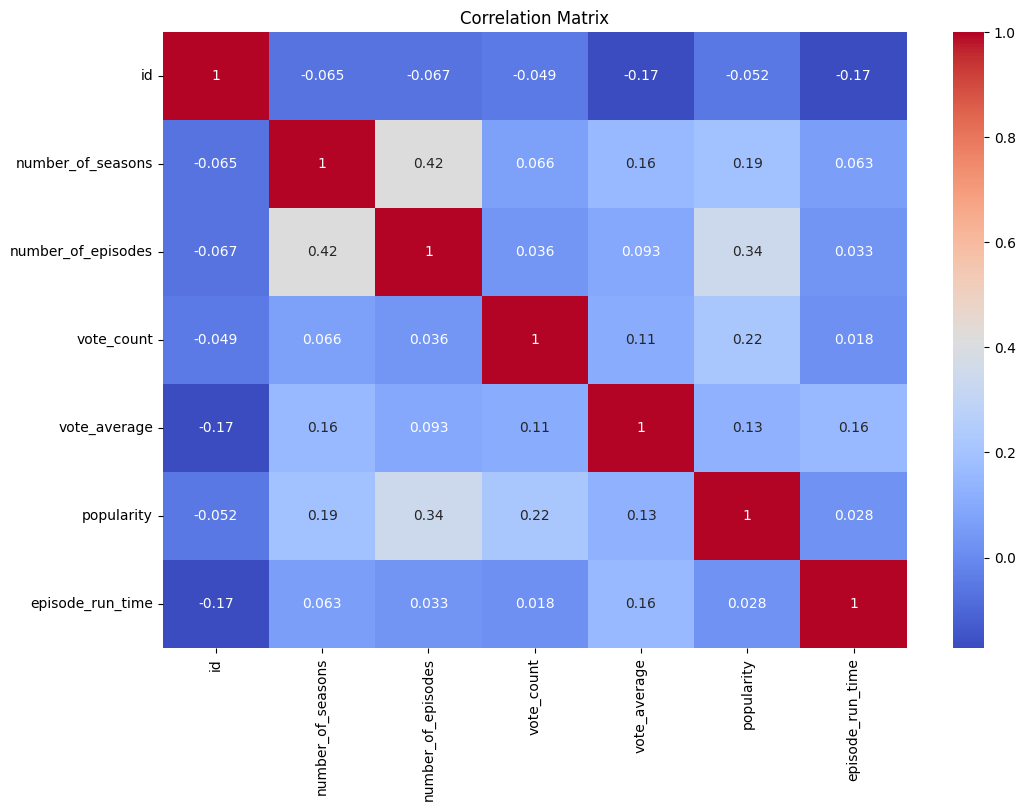

In [3]:
'''
creating a corelation matrix with numeric data
'''
numeric_data = df.select_dtypes(include='number')
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Correlation Matrix Insights
* 'number_of_seasons' and 'number_of_episodes' have a correlation of 0.42. This shows us that we have a moderately positive correlation, which makes sense since a show with more seasons tends to have more episodes
* 'vote_count' and 'popularity' have a correlation of 0.22, which is a weak positive correlation. This means that shows with more votes are slighly more popular, but it is not a strong relationship
* 'number_of_episodes' and 'popularity' have a correlation of 0.34, which is a moderatly positive correlation. This means that shows with more episodes tend to be more popular
* 'vote_average' and 'episode_run_time' have a correlation of 0.16, which is a weak positive corelation. This could mean that longer-running episodes might have a slightly higher average rating

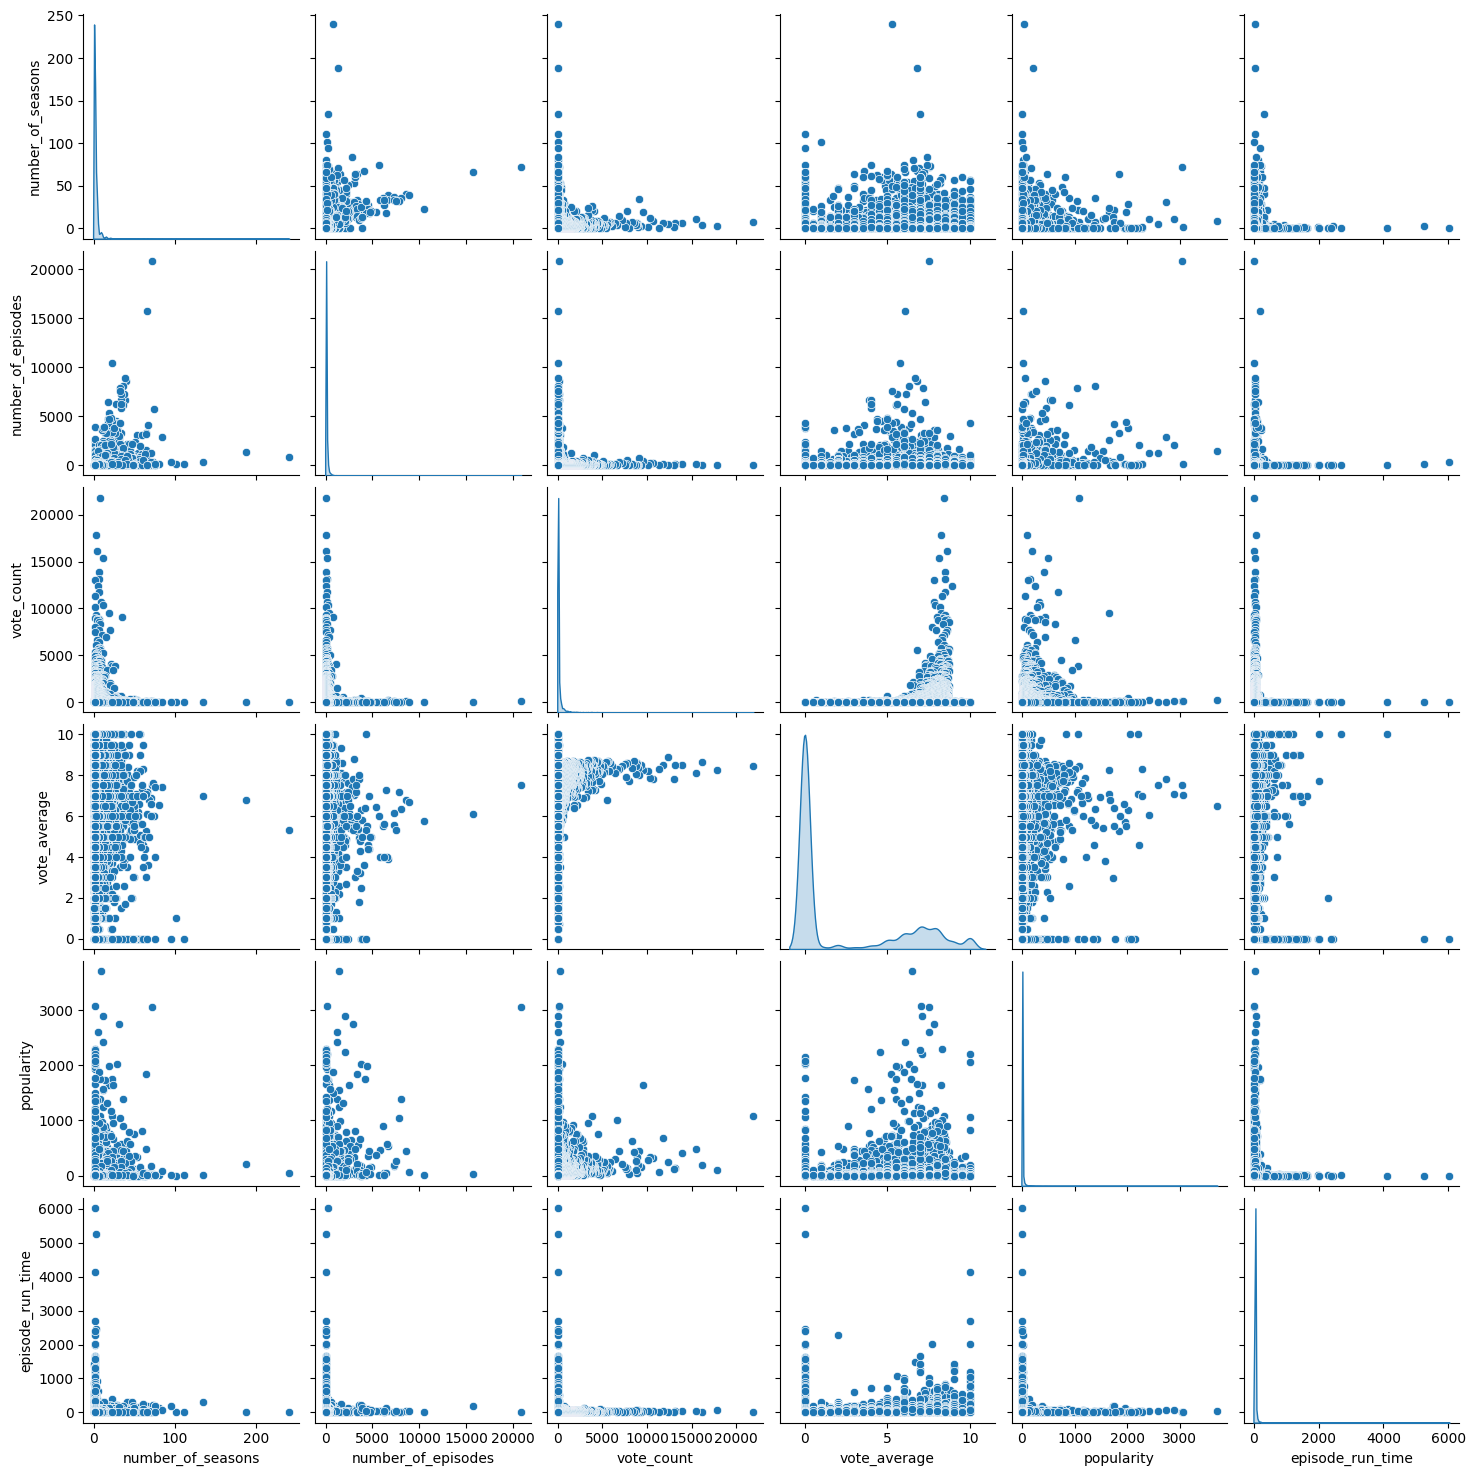

In [4]:
'''
creating a pair plot to examine the pairwise relationships between multiple features
'''
sns.pairplot(df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']], diag_kind='kde')
plt.show()

### Pair Plot Insights
* The scatter plots off the diagonal represent a relationship between two variables, while the diagonal plots show the distribution of a single varaible
* 'number_of_seasons' and 'number_of_episodes' have more of a linear relationship since shows with more seasons mostly have more episodes
* there are many distributions (like 'number_of_seasons' and 'vote_count') that are heavily skewed, with a large number of shows having a low count and only a few having very high values
* outliers are visible, like 'number_of_episodes' vs. 'vote_count' has some shows with a significantly high vote count compared to others

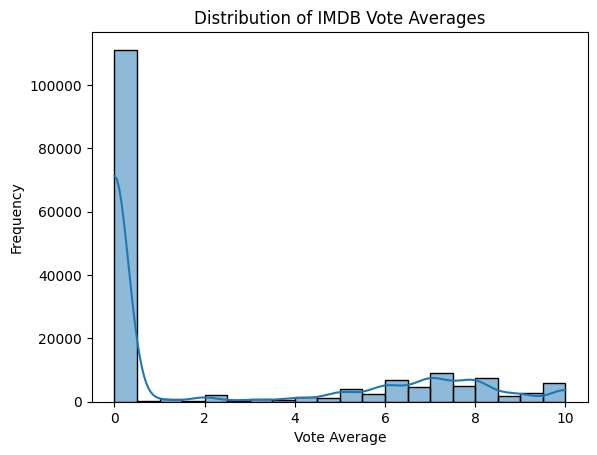

In [5]:
'''
histogram and KDE for vote_agerage
'''
sns.histplot(df['vote_average'], kde=True, bins=20)
plt.title('Distribution of IMDB Vote Averages')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()

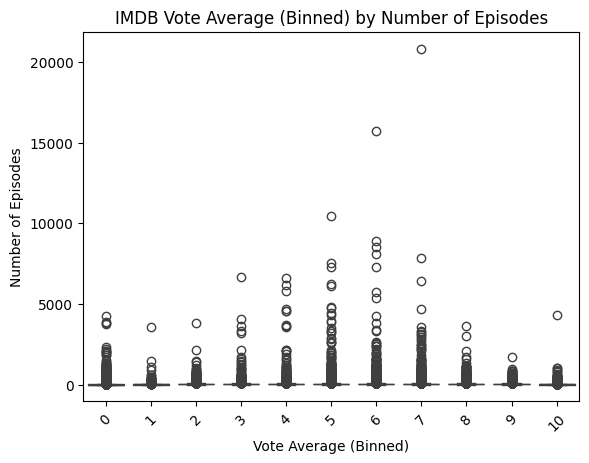

In [6]:
'''
boxplot to compare vote_average by number_of_episodes by first creating bins for the vote_average
'''

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # modify bins to include 10
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # 12 edges, include a bin for values 10-11

df['vote_average_binned'] = pd.cut(df['vote_average'], bins=bins, labels=labels, right=False)

sns.boxplot(x='vote_average_binned', y='number_of_episodes', data=df)
plt.title('IMDB Vote Average (Binned) by Number of Episodes')
plt.xticks(rotation=45)
plt.xlabel('Vote Average (Binned)')
plt.ylabel('Number of Episodes')
plt.show()

In [7]:
df = df.drop('vote_average_binned', axis=1)

## Visualizing Distributions (Histograms)

In [8]:
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

In [9]:
df[numerical_columns].describe()

,number_of_seasons,number_of_episodes,vote_count,vote_average,popularity,episode_run_time
count,168639.000000,168639.000000,168639.000000,168639.000000,168639.000000,168639.000000
mean,1.548497,24.465082,13.305054,2.333843,5.882644,22.603348
std,2.942872,134.799622,190.809059,3.454334,42.023216,47.950427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.600000,0.000000
50%,1.000000,6.000000,0.000000,0.000000,0.857000,0.000000
75%,1.000000,20.000000,1.000000,6.000000,2.431500,42.000000
max,240.000000,20839.000000,21857.000000,10.000000,3707.008000,6032.000000


In [10]:
"""
# Regular Histograms

df[numerical_columns].hist(figsize=(12, 10), bins=15)
plt.suptitle('Histograms of Numerical Columns')
plt.show()
"""

"\n# Regular Histograms\n\ndf[numerical_columns].hist(figsize=(12, 10), bins=15)\nplt.suptitle('Histograms of Numerical Columns')\nplt.show()\n"

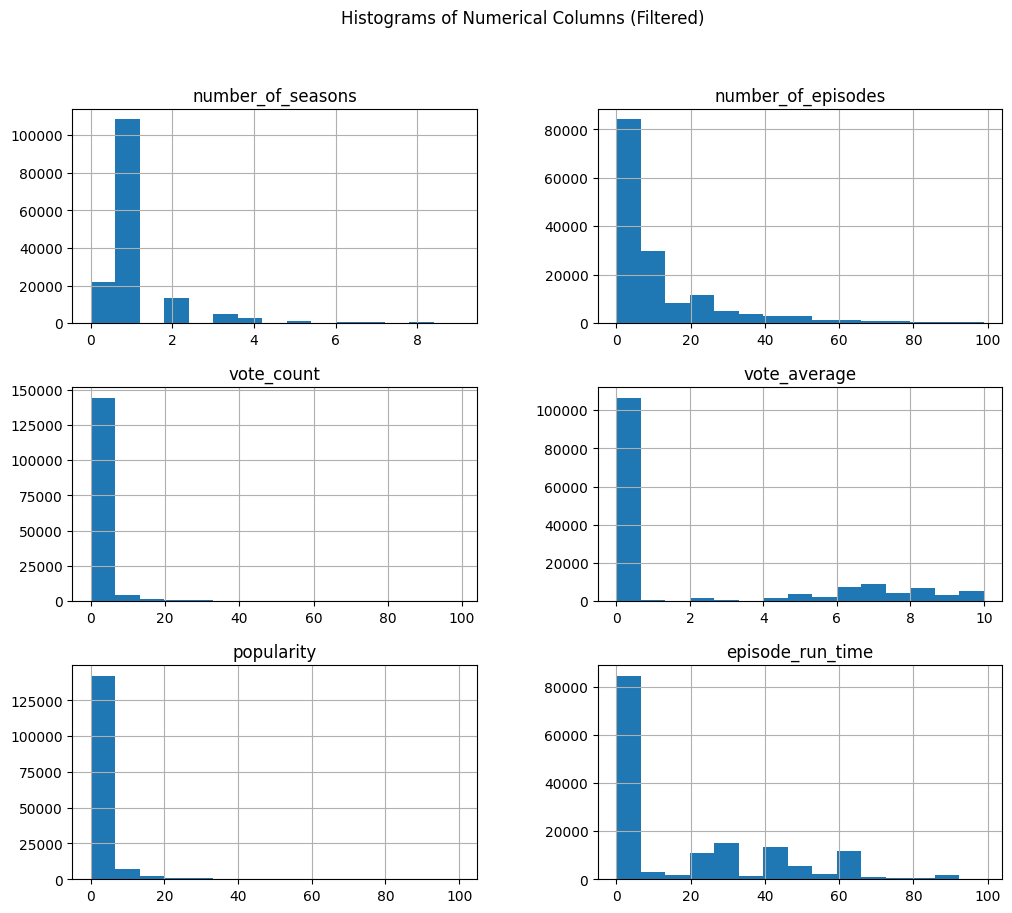

In [11]:
# Filter the DataFrame so it is easier to visualize without outliers
filtered_df = df[
    (df['number_of_seasons'] < 10) &
    (df['number_of_episodes'] < 100) &
    (df['vote_count'] < 100) &
    (df['popularity'] < 100) &
    (df['episode_run_time'] < 100)
]

# Plotting the histograms for the filtered data
filtered_df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']].hist(
    figsize=(12, 10), bins=15)

plt.suptitle('Histograms of Numerical Columns (Filtered)')
plt.show()


### Histogram Insights

- The histograms indicate that most of the numerical columns in the dataset have highly skewed distributions. (i.e, 'number_of_seasons' and 'number_of_episodes'  are clearly right-skewed)

- A small number of extreme values dominate the range indicating that outliers are present.

- We must deal with this to improve our models, so we should do log transformation and look at the outliers to see if we should discard them.

- **Feature Engineering Suggestions**: Log Transformation of numerical columns to potentially aid in skewness

- **Pre-processing Suggestions**: Outlier Analysis to improve predictive performance

## Distribution of TV-Shows without Zeroes + Understanding Amount of Zeross in Dataset

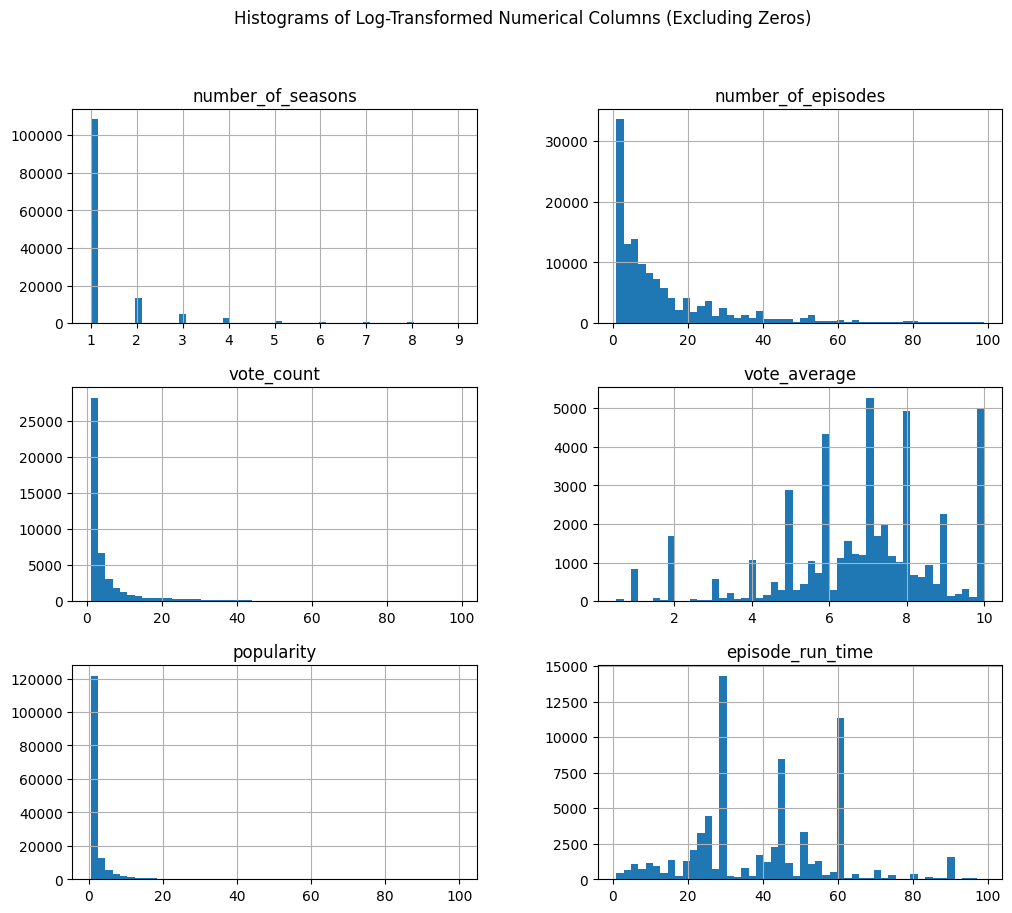

In [12]:
# Replace zeros with NaN to exclude them temporarily
df_nonzero = filtered_df[numerical_columns].replace(0, np.nan)
df_nonzero.hist(figsize=(12, 10), bins=50)
plt.suptitle('Histograms of Log-Transformed Numerical Columns (Excluding Zeros)')
plt.show()

In [13]:
threshold = 0.001

near_zero_counts = {}

for col in numerical_columns:
    count_near_zero = df[df[col] <= threshold].shape[0]
    percentage_near_zero = (count_near_zero / df.shape[0]) * 100
    near_zero_counts[col] = {'count': count_near_zero, 'percentage': percentage_near_zero}

near_zero_df = pd.DataFrame.from_dict(near_zero_counts, orient='index')
near_zero_df.columns = ['Count Near Zero (below 0.001)', 'Percentage Near Zero']

print(near_zero_df)

                    Count Near Zero (below 0.001)  Percentage Near Zero
number_of_seasons                           22428             13.299415
number_of_episodes                          24016             14.241071
vote_count                                 111137             65.902312
vote_average                               111135             65.901126
popularity                                   2385              1.414264
episode_run_time                            85315             50.590314


## Outlier Analysis (Using Interquartile Method)

In [14]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as points below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outliers = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR)))

# Number of outliers in each column
outliers_count = outliers.sum()
print("Number of Outliers in each column: \n", outliers_count)

Number of Outliers in each column: 
 number_of_seasons     54613
number_of_episodes    16793
vote_count            26221
vote_average              0
popularity            24368
episode_run_time       2868
dtype: int64


- Suggestions: Winsorize outliers after log transformation

In [15]:
df.to_csv("TMDB_tv_dataset_v3.csv", index=False)